<a href="https://colab.research.google.com/github/liuying1201/Credit-Risk-Prediction-German-Bank/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd

# 上傳文件
uploaded = files.upload()

# 讀取上傳的CSV文件
train_data = pd.read_csv('train_data.csv')  # 確保文件名與上傳的文件名一致
test_data = pd.read_csv('test_data.csv')  # 確保文件名與上傳的文件名一致
completed_data = pd.read_csv('completed_data_transformed_final.csv')  # 確保文件名與上傳的文件名一致


Saving completed_data_transformed_final.csv to completed_data_transformed_final (1).csv
Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv


In [ ]:
# 選擇正確的特徵名稱（包括空格）
selected_features = ['Credit amount', 'Age', 'Duration', 'Purpose', 'Checking account', 'Housing', 'Saving accounts']

# 分割特徵和目標變量
X = train_data[selected_features]
y = train_data['Risk']


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# 分割為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 使用 SMOTETomek 進行數據平衡
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)


In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# 定義參數網格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'num_leaves': [20, 31, 50]
}

# 建立 LightGBM 模型
lgb_model = lgb.LGBMClassifier(random_state=42)

# 使用 GridSearchCV 進行參數搜索
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# 訓練模型
grid_search_lgb.fit(X_train_resampled, y_train_resampled)

# 顯示最佳參數
print(f"最佳參數: {grid_search_lgb.best_params_}")
print(f"最佳準確度: {grid_search_lgb.best_score_}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 298, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
# 使用最佳參數重新訓練 LightGBM 模型
best_lgb_model = lgb.LGBMClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=9,
    min_child_weight=3,
    n_estimators=200,
    num_leaves=20,
    subsample=0.8,
    random_state=42
)

# 在訓練集上重新訓練模型
best_lgb_model.fit(X_train_resampled, y_train_resampled)

# 在測試集上進行預測
y_pred_best_lgb = best_lgb_model.predict(X_test)

# 評估模型性能
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_best_lgb = accuracy_score(y_test, y_pred_best_lgb)
print(f"測試集上的準確度: {accuracy_best_lgb:.2f}")
print(classification_report(y_test, y_pred_best_lgb))
print(confusion_matrix(y_test, y_pred_best_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 298, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [ ]:
# 獲取預測的概率
y_pred_probs = best_lgb_model.predict_proba(X_test)[:, 1]

# 設定新的閾值，例如 0.4 而不是默認的 0.5
new_threshold = 0.4
y_pred_adjusted = (y_pred_probs >= new_threshold).astype(int)

# 重新計算召回率、精確度和其他指標
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74       138
         1.0       0.49      0.47      0.48        72

    accuracy                           0.65       210
   macro avg       0.61      0.61      0.61       210
weighted avg       0.65      0.65      0.65       210

[[103  35]
 [ 38  34]]


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 重新訓練模型
best_lgb_model.fit(X_train_resampled, y_train_resampled)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 353, number of negative: 353
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 706, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

LGBMClassifier(learning_rate=0.2, max_depth=9, min_child_weight=3,
               n_estimators=200, num_leaves=20, random_state=42, subsample=0.8)

In [ ]:
# 調整類別權重，使得高風險類別有更大的權重
best_lgb_model = lgb.LGBMClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=9,
    min_child_weight=3,
    n_estimators=200,
    num_leaves=20,
    subsample=0.8,
    class_weight={0: 1, 1: 3},  # 給高風險類別更多權重
    random_state=42
)

# 重新訓練模型
best_lgb_model.fit(X_train_resampled, y_train_resampled)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 353, number of negative: 353
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 706, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMClassifier(class_weight={0: 1, 1: 3}, learning_rate=0.2, max_depth=9,
               min_child_weight=3, n_estimators=200, num_leaves=20,
               random_state=42, subsample=0.8)

In [ ]:
# 進一步的超參數調整
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [9, 10, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'num_leaves': [20, 30, 40]
}

grid_search_lgb = GridSearchCV(estimator=best_lgb_model, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='recall')

# 訓練模型
grid_search_lgb.fit(X_train_resampled, y_train_resampled)

# 使用最佳參數重新訓練
best_lgb_model = grid_search_lgb.best_estimator_


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 353, number of negative: 353
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 706, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
X_train_resampled.columns = X_train_resampled.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 訓練隨機森林模型
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

# 預測並評估
y_pred_rf = rf_model.predict(X_test)
print("隨機森林模型的性能:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


隨機森林模型的性能:
              precision    recall  f1-score   support

         0.0       0.74      0.79      0.76       138
         1.0       0.54      0.47      0.50        72

    accuracy                           0.68       210
   macro avg       0.64      0.63      0.63       210
weighted avg       0.67      0.68      0.68       210

[[109  29]
 [ 38  34]]


In [ ]:
import xgboost as xgb

# 訓練 XGBoost 模型
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]))
xgb_model.fit(X_train_resampled, y_train_resampled)

# 預測並評估
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost 模型的性能:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost 模型的性能:
              precision    recall  f1-score   support

         0.0       0.72      0.82      0.77       138
         1.0       0.54      0.40      0.46        72

    accuracy                           0.68       210
   macro avg       0.63      0.61      0.61       210
weighted avg       0.66      0.68      0.66       210

[[113  25]
 [ 43  29]]


In [ ]:
from sklearn.svm import SVC

# 訓練 SVM 模型
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

# 預測並評估
y_pred_svm = svm_model.predict(X_test)
print("支持向量機模型的性能:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


支持向量機模型的性能:
              precision    recall  f1-score   support

         0.0       0.74      0.50      0.60       138
         1.0       0.41      0.67      0.51        72

    accuracy                           0.56       210
   macro avg       0.58      0.58      0.55       210
weighted avg       0.63      0.56      0.57       210

[[69 69]
 [24 48]]


In [ ]:
from sklearn.linear_model import LogisticRegression

# 訓練邏輯回歸模型
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

# 預測並評估
y_pred_lr = lr_model.predict(X_test)
print("邏輯回歸模型的性能:")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))


邏輯回歸模型的性能:
              precision    recall  f1-score   support

         0.0       0.74      0.67      0.70       138
         1.0       0.46      0.54      0.50        72

    accuracy                           0.62       210
   macro avg       0.60      0.60      0.60       210
weighted avg       0.64      0.62      0.63       210

[[92 46]
 [33 39]]


In [ ]:
from sklearn.naive_bayes import GaussianNB

# 訓練貝葉斯分類器
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# 預測並評估
y_pred_nb = nb_model.predict(X_test)
print("貝葉斯分類器的性能:")
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))


貝葉斯分類器的性能:
              precision    recall  f1-score   support

         0.0       0.73      0.46      0.56       138
         1.0       0.40      0.68      0.50        72

    accuracy                           0.53       210
   macro avg       0.56      0.57      0.53       210
weighted avg       0.62      0.53      0.54       210

[[63 75]
 [23 49]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 訓練隨機森林模型
rf_model = RandomForestClassifier(
    n_estimators=200,  # 可以根據需要調整
    max_depth=None,    # 可以根據需要調整
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train_resampled, y_train_resampled)

# 在測試集上進行預測
y_pred_rf = rf_model.predict(X_test)

# 評估模型性能
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"隨機森林模型的準確度: {accuracy_rf:.2f}")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


隨機森林模型的準確度: 0.67
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75       138
         1.0       0.52      0.47      0.49        72

    accuracy                           0.67       210
   macro avg       0.63      0.62      0.62       210
weighted avg       0.66      0.67      0.66       210

[[106  32]
 [ 38  34]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 定義參數網格
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # 樹的數量
    'max_depth': [None, 10, 20, 30],       # 樹的最大深度
    'min_samples_split': [2, 5, 10],       # 節點分裂所需的最小樣本數
    'min_samples_leaf': [1, 2, 4],         # 葉子節點所需的最小樣本數
    'max_features': ['auto', 'sqrt', 'log2'],  # 每次分裂所使用的特徵數量
    'bootstrap': [True, False],            # 是否使用自助抽樣法
    'class_weight': ['balanced', 'balanced_subsample', None]  # 處理不平衡數據的權重
}

# 初始化隨機森林分類器
rf_model = RandomForestClassifier(random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# 執行網格搜索
grid_search.fit(X_train_resampled, y_train_resampled)

# 顯示最佳參數
print(f"最佳參數: {grid_search.best_params_}")
print(f"最佳準確度: {grid_search.best_score_}")


Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


KeyboardInterrupt: 

In [ ]:
# 使用最佳參數重新訓練隨機森林模型
best_rf_model = RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

# 訓練模型
best_rf_model.fit(X_train_resampled, y_train_resampled)

# 在測試集上進行預測
y_pred_best_rf = best_rf_model.predict(X_test)

# 評估模型性能
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"最佳隨機森林模型的準確度: {accuracy_best_rf:.2f}")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


In [ ]:
# 獲取預測概率
y_pred_probs = best_rf_model.predict_proba(X_test)[:, 1]

# 設定新的閾值，例如 0.4 而不是默認的 0.5
new_threshold = 0.4
y_pred_adjusted = (y_pred_probs >= new_threshold).astype(int)

# 重新計算性能指標
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


NameError: name 'best_rf_model' is not defined

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    # 其他參數保持不變
}


In [ ]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    # 其他參數保持不變
}


In [ ]:
param_grid = {
    'min_samples_split': [2, 5, 10],
    # 其他參數保持不變
}


In [ ]:
param_grid = {
    'min_samples_leaf': [1, 2, 4],
    # 其他參數保持不變
}


In [ ]:
param_grid = {
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    # 其他參數保持不變
}


In [ ]:
param_grid = {
    'bootstrap': [True, False],
    # 其他參數保持不變
}


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

grid_search.fit(X_train_resampled, y_train_resampled)

print(f"最佳參數: {grid_search.best_params_}")
print(f"最佳準確度: {grid_search.best_score_}")


In [ ]:
# 使用最佳參數重新訓練隨機森林模型
best_rf_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# 訓練模型
best_rf_model.fit(X_train_resampled, y_train_resampled)

# 在測試集上進行預測
y_pred_best_rf = best_rf_model.predict(X_test)

# 評估模型性能
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"最佳隨機森林模型的準確度: {accuracy_best_rf:.2f}")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


In [ ]:
# 獲取預測概率
y_pred_probs = best_rf_model.predict_proba(X_test)[:, 1]

# 調整閾值
new_threshold = 0.4  # 你可以嘗試不同的值
y_pred_adjusted = (y_pred_probs >= new_threshold).astype(int)

# 重新計算性能指標
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
# 在訓練和測試數據集中統一特徵名稱
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

# 如果在過採樣後出現相同問題，對過採樣後的數據也進行相同操作
X_resampled.columns = X_resampled.columns.str.replace(' ', '_')


In [ ]:
# 使用統一特徵名稱的數據重新訓練模型
best_rf_model.fit(X_resampled, y_resampled)

# 在測試集上進行預測
y_pred_resampled = best_rf_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred_resampled))
print(confusion_matrix(y_test, y_pred_resampled))


In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=len(y_train)/sum(y_train), random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


In [ ]:
y_pred_probs = best_rf_model.predict_proba(X_test)[:, 1]
new_threshold = 0.4  # 或者更低
y_pred_adjusted = (y_pred_probs >= new_threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 加載並分割數據
# X_train, X_test, y_train, y_test 已經定義好了

# 使用 SMOTE 進行過採樣
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 使用過採樣後的數據訓練隨機森林模型
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# 在測試集上進行預測
y_pred_rf = rf_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


In [ ]:
from xgboost import XGBClassifier

# 訓練 XGBoost 模型
xgb_model = XGBClassifier(scale_pos_weight=len(y_train)/sum(y_train), random_state=42)
xgb_model.fit(X_resampled, y_resampled)

# 在測試集上進行預測
y_pred_xgb = xgb_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 定義基礎模型
clf1 = RandomForestClassifier(random_state=42)
clf2 = XGBClassifier(random_state=42)
clf3 = LogisticRegression(random_state=42)
clf4 = SVC(probability=True, random_state=42)

# 使用投票分類器
voting_clf = VotingClassifier(estimators=[('rf', clf1), ('xgb', clf2), ('lr', clf3), ('svc', clf4)], voting='soft')
voting_clf.fit(X_resampled, y_resampled)

# 在測試集上進行預測
y_pred_voting = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred_voting))
print(confusion_matrix(y_test, y_pred_voting))


In [ ]:
from sklearn.model_selection import GridSearchCV

# 設置參數網格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# 創建模型
rf_model = RandomForestClassifier(random_state=42)

# 使用GridSearchCV進行參數搜索
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# 獲取最佳模型
best_rf_model = grid_search.best_estimator_

# 在測試集上進行預測
y_pred_best_rf = best_rf_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


In [ ]:
from sklearn.ensemble import VotingClassifier

# 定義基礎模型
clf1 = RandomForestClassifier(n_estimators=200, random_state=42)
clf2 = XGBClassifier(n_estimators=200, random_state=42)
clf3 = LogisticRegression(random_state=42)

# 使用投票分類器
voting_clf = VotingClassifier(estimators=[('rf', clf1), ('xgb', clf2), ('lr', clf3)], voting='soft')
voting_clf.fit(X_resampled, y_resampled)

# 在測試集上進行預測
y_pred_voting = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred_voting))
print(confusion_matrix(y_test, y_pred_voting))


In [ ]:
# 獲取預測概率
y_pred_probs = best_rf_model.predict_proba(X_test)[:, 1]

# 調整閾值
new_threshold = 0.45  # 試試其他值，如 0.4 或 0.5
y_pred_adjusted = (y_pred_probs >= new_threshold).astype(int)

# 評估模型性能
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# 設置參數範圍
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 創建模型
rf_model = RandomForestClassifier(random_state=42)

# 使用RandomizedSearchCV進行隨機搜索
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_resampled, y_resampled)

# 獲取最佳模型
best_rf_model = random_search.best_estimator_

# 在測試集上進行預測
y_pred_best_rf = best_rf_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8],
    'bootstrap': [True, False]
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# 設置參數範圍
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8],
    'bootstrap': [True, False]
}

# 創建隨機森林模型
rf_model = RandomForestClassifier(random_state=42)

# 使用RandomizedSearchCV進行隨機搜索
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_resampled, y_resampled)

# 獲取最佳模型
best_rf_model = random_search.best_estimator_

# 在測試集上進行預測
y_pred_best_rf = best_rf_model.predict(X_test)

# 評估模型性能
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# 設置參數範圍
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.8],
    'bootstrap': [True, False]
}

# 創建隨機森林模型
rf_model = RandomForestClassifier(random_state=42)

# 使用RandomizedSearchCV進行隨機搜索
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_resampled, y_resampled)

# 獲取最佳模型
best_rf_model = random_search.best_estimator_

# 在測試集上進行預測
y_pred_best_rf = best_rf_model.predict(X_test)

# 評估模型性能
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


In [ ]:
# 獲取預測概率
y_pred_probs = best_rf_model.predict_proba(X_test)[:, 1]

# 調整閾值
new_threshold = 0.4  # 試試不同的閾值，如 0.4 或 0.6
y_pred_adjusted = (y_pred_probs >= new_threshold).astype(int)

# 評估調整後的模型性能
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
# 調整分類閾值
y_pred_probs = best_rf_model.predict_proba(X_test)[:, 1]
new_threshold = 0.4  # 試試 0.4 或其他值
y_pred_adjusted = (y_pred_probs >= new_threshold).astype(int)

# 評估調整後的模型性能
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)


In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('rf', best_rf_model), ('xgb', xgb_model), ('lr', lr_model)],
    voting='soft'
)
voting_clf.fit(X_resampled, y_resampled)
y_pred_ensemble = voting_clf.predict(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, confusion_matrix

# 標準化特徵
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# 使用 SMOTETomek 進行數據平衡
smote_tomek = SMOTETomek(random_state=42)
X_resampled_balanced, y_resampled_balanced = smote_tomek.fit_resample(X_resampled_scaled, y_resampled)

# 訓練最佳隨機森林模型
best_rf_model = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=42)
best_rf_model.fit(X_resampled_balanced, y_resampled_balanced)

# 預測測試集
y_pred = best_rf_model.predict(X_test_scaled)

# 評估模型性能
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [ ]:
from imblearn.over_sampling import SMOTE

# 創建 SMOTE 物件
smote = SMOTE(random_state=42)

# 使用 SMOTE 進行過採樣
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 檢查過採樣後的樣本分佈
print("過採樣後的樣本分佈:")
print(pd.Series(y_resampled).value_counts())


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 使用過採樣後的數據進行訓練
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# 在測試集上進行預測
y_pred = rf_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [ ]:
# 獲取預測概率
y_pred_probs = rf_model.predict_proba(X_test)[:, 1]

# 調整分類閾值
new_threshold = 0.4  # 可以嘗試不同的閾值，如 0.4, 0.5, 0.6
y_pred_adjusted = (y_pred_probs >= new_threshold).astype(int)

# 評估調整後的模型性能
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
# 試驗不同的分類閾值
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
for threshold in thresholds:
    y_pred_adjusted = (y_pred_probs >= threshold).astype(int)
    print(f"分類閾值: {threshold}")
    print(classification_report(y_test, y_pred_adjusted))
    print(confusion_matrix(y_test, y_pred_adjusted))
    print("\n")


In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
# 訓練隨機森林模型
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
rf_model.fit(X_train_resampled, y_train_resampled)

# 訓練 XGBoost 模型
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=5)
xgb_model.fit(X_train_resampled, y_train_resampled)

# 訓練邏輯回歸模型
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)


In [ ]:
# 創建投票分類器
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lr', lr_model)],
    voting='soft'  # 'hard' 或 'soft'
)

# 訓練投票分類器
voting_model.fit(X_train_resampled, y_train_resampled)


In [ ]:
# 在測試集上進行預測
y_pred_voting = voting_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred_voting))
print(confusion_matrix(y_test, y_pred_voting))


In [ ]:
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lr', lr_model)],
    voting='soft',
    weights=[2, 2, 1]  # 假設隨機森林和XGBoost表現較好
)
voting_model.fit(X_train_resampled, y_train_resampled)


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# 假設你已經有了 X_train_resampled, y_train_resampled, X_test, y_test

# 1. 初始化各個基礎模型
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=5)
lr_model = LogisticRegression(random_state=42)

# 2. 將這些模型組合成 VotingClassifier
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lr', lr_model)],
    voting='soft'  # 'soft' 會使用各模型的預測概率進行加權投票
)

# 3. 訓練 VotingClassifier 模型
voting_model.fit(X_train_resampled, y_train_resampled)

# 4. 使用測試集進行預測
y_pred_voting = voting_model.predict(X_test)

# 5. 評估模型性能
print(classification_report(y_test, y_pred_voting))
print(confusion_matrix(y_test, y_pred_voting))


In [ ]:
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lr', lr_model)],
    voting='soft',
    weights=[2, 3, 1]  # 為 XGBoost 設置更高的權重
)


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# 假設你已經有了 X_train_resampled, y_train_resampled, X_test, y_test

# 1. 初始化各個基礎模型
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=5)
lr_model = LogisticRegression(random_state=42)

# 2. 將這些模型組合成 VotingClassifier
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lr', lr_model)],
    voting='soft'  # 'soft' 會使用各模型的預測概率進行加權投票
)

# 3. 訓練 VotingClassifier 模型
voting_model.fit(X_train_resampled, y_train_resampled)

# 4. 使用測試集進行預測
y_pred_voting = voting_model.predict(X_test)

# 5. 評估模型性能
print(classification_report(y_test, y_pred_voting))
print(confusion_matrix(y_test, y_pred_voting))


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # 支持向量機
from sklearn.metrics import classification_report, confusion_matrix

# 初始化各個基礎模型
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=5)
lr_model = LogisticRegression(random_state=42)
svm_model = SVC(probability=True, random_state=42)  # 設置 probability=True 以獲得預測概率

# 將這些模型組合成 VotingClassifier
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lr', lr_model), ('svm', svm_model)],
    voting='soft'  # 'soft' 會使用各模型的預測概率進行加權投票
)

# 訓練 VotingClassifier 模型
voting_model.fit(X_train_resampled, y_train_resampled)

# 使用測試集進行預測
y_pred_voting = voting_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred_voting))
print(confusion_matrix(y_test, y_pred_voting))


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

# 假設你已經有了原始數據框 data
data = pd.read_csv('completed_data_transformed_final.csv')  # 示例文件名

# 選擇特徵並進行編碼
features = ['Credit amount', 'Age', 'Duration', 'Purpose', 'Checking account', 'Housing', 'Saving accounts']
target = 'Risk'

# 將分類特徵進行編碼
encoder = OrdinalEncoder()
data[features] = encoder.fit_transform(data[features])

# 對數值型特徵進行標準化
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# 分割訓練集和測試集
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# 讀取數據
data = pd.read_csv('completed_data_transformed_final.csv')  # 示例文件名

# 選擇特徵並進行編碼
features = ['Credit amount', 'Age', 'Duration', 'Purpose', 'Checking account', 'Housing', 'Saving accounts']
target = 'Risk'

# 將分類特徵進行編碼
encoder = OrdinalEncoder()
data[features] = encoder.fit_transform(data[features])

# 對數值型特徵進行標準化
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# 分割訓練集和測試集
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 初始化各模型
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42)
svm_model = SVC(probability=True, random_state=42)

# 隨機森林模型的參數調優
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
grid_rf = GridSearchCV(rf_model, rf_params, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print(f'最佳隨機森林參數: {grid_rf.best_params_}')

# XGBoost 模型的參數調優
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_xgb = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy')
grid_xgb.fit(X_train, y_train)
print(f'最佳 XGBoost 參數: {grid_xgb.best_params_}')

# 使用最優參數重新初始化模型
rf_best = grid_rf.best_estimator_
xgb_best = grid_xgb.best_estimator_

# 集成模型
voting_model = VotingClassifier(
    estimators=[('rf', rf_best), ('xgb', xgb_best), ('lr', lr_model), ('svm', svm_model)],
    voting='soft'
)

# 訓練集成模型
voting_model.fit(X_train, y_train)

# 使用測試集進行預測
y_pred = voting_model.predict(X_test)

# 評估模型性能
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 讀取數據
data = pd.read_csv('completed_data_transformed_final.csv')  # 示例文件名

# 選擇特徵並進行編碼
features = ['Credit amount', 'Age', 'Duration', 'Purpose', 'Checking account', 'Housing', 'Saving accounts']
target = 'Risk'

# 將分類特徵進行編碼
encoder = OrdinalEncoder()
data[features] = encoder.fit_transform(data[features])

# 對數值型特徵進行標準化
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# 分割訓練集和測試集
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 使用 SMOTE 進行過採樣
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 使用最優參數重新訓練模型
rf_best = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
xgb_best = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42)
lr_model = LogisticRegression(random_state=42)

rf_best.fit(X_train_resampled, y_train_resampled)
xgb_best.fit(X_train_resampled, y_train_resampled)

# 集成模型
voting_model = VotingClassifier(
    estimators=[('rf', rf_best), ('xgb', xgb_best), ('lr', lr_model)],
    voting='soft'
)

voting_model.fit(X_train_resampled, y_train_resampled)

# 預測測試集
y_pred_prob = voting_model.predict_proba(X_test)[:, 1]

# 調整分類閾值
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
optimal_threshold = thresholds[np.argmax(precision * recall)]
y_pred_adjusted = (y_pred_prob >= optimal_threshold).astype(int)

# 評估模型性能
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
import matplotlib.pyplot as plt

# 繪製 precision-recall 曲線
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend(loc="best")
plt.show()

# 選擇一個更合適的閾值
new_threshold = 0.4  # 假設你在曲線中觀察到這個閾值比較合適
y_pred_adjusted = (y_pred_prob >= new_threshold).astype(int)

# 再次評估模型
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
# 假設使用已經計算的預測概率
y_pred_prob = voting_model.predict_proba(X_test)[:, 1]

# 使用新的分類閾值 0.35
new_threshold = 0.35
y_pred_adjusted = (y_pred_prob >= new_threshold).astype(int)

# 評估模型
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
# 使用新的分類閾值 0.375
new_threshold = 0.375
y_pred_adjusted = (y_pred_prob >= new_threshold).astype(int)

# 再次評估模型
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
# 再次調整閾值，如使用0.4或其他值
new_threshold = 0.4
y_pred_adjusted = (y_pred_prob >= new_threshold).astype(int)

# 評估模型
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 假設你已經有了特徵數據X和目標變量y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 建立基礎模型
rf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(solver='liblinear', random_state=42)

# 建立SVM模型並標準化數據
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, random_state=42))

# 使用堆疊模型
estimators = [('rf', rf), ('xgb', xgb), ('lr', lr), ('svm', svm)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=StratifiedKFold(n_splits=5))

# 訓練堆疊模型
stacking_model.fit(X_train, y_train)

# 預測概率
y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]

# 計算precision-recall曲線
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# 調整閾值以最大化precision與recall的乘積
optimal_threshold = thresholds[np.argmax(precision * recall)]
y_pred_adjusted = (y_pred_prob >= optimal_threshold).astype(int)

# 評估調整後模型的性能
print(classification_report(y_test, y_pred_adjusted))

# 可視化precision-recall vs threshold曲線
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 檢查數據的描述性統計量
print(data.describe())

# 使用箱線圖來檢查異常值
plt.figure(figsize=(15, 10))
sns.boxplot(data=data)
plt.show()


In [ ]:
import pandas as pd

# 假設 train_data 和 test_data 是您已經加載的數據集
train_data = train_data.drop(columns=['Unnamed: 0'])
test_data = test_data.drop(columns=['Unnamed: 0'])

# 檢查刪除後的數據
print(train_data.head())
print(test_data.head())


In [ ]:
# 使用 IQR 方法檢查和處理異常值
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# 定義異常值的範圍
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 過濾異常值
data_cleaned = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 分割數據
X = data_cleaned.drop(columns=['Risk'])
y = data_cleaned['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 訓練隨機森林模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# 預測和評估
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 定義各模型
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=3)
lr = LogisticRegression()

# 組合成投票分類器
voting_model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('lr', lr)], voting='soft')

# 訓練投票分類器
voting_model.fit(X_train, y_train)

# 預測和評估
y_pred = voting_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


In [ ]:
lr = LogisticRegression(max_iter=1000)  # 增加最大迭代次數


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
threshold = 0.3  # 您可以嘗試不同的閾值
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 假設 X 和 y 是特徵矩陣和目標變量
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 標準化數據
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 訓練邏輯回歸模型，增加最大迭代次數
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# 預測測試集
y_pred = lr_model.predict(X_test_scaled)

# 評估模型
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 分割訓練和測試數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 訓練 RandomForestClassifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 訓練 XGBoostClassifier
xgb_model = XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), random_state=42)
xgb_model.fit(X_train, y_train)

# 評估模型性能
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_pred))


In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

# 使用 ADASYN 進行過採樣
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# 使用欠採樣技術
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# 使用平衡後的數據集訓練模型
rf_model.fit(X_resampled, y_resampled)
xgb_model.fit(X_resampled, y_resampled)

# 評估模型
rf_pred_resampled = rf_model.predict(X_test)
xgb_pred_resampled = xgb_model.predict(X_test)

print("Resampled Random Forest Classification Report:\n", classification_report(y_test, rf_pred_resampled))
print("Resampled XGBoost Classification Report:\n", classification_report(y_test, xgb_pred_resampled))


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 使用 SMOTE 進行過採樣
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 定義基礎模型
estimators = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), random_state=42)),
    ('lr', LogisticRegression(max_iter=1000))
]

# 使用堆疊模型
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stacking_model.fit(X_resampled, y_resampled)

# 評估模型性能
stacking_pred = stacking_model.predict(X_test)
print("Stacking Model Classification Report:\n", classification_report(y_test, stacking_pred))


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report

# 定義更多基礎模型
estimators = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=3, random_state=42)),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000)),
    ('svm', SVC(probability=True, class_weight='balanced', random_state=42))
]

# 使用 AdaBoost 作為最終分類器進行堆疊
stacking_model = StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier(), cv=5)
stacking_model.fit(X_resampled, y_resampled)

# 在測試集上進行預測
stacking_pred = stacking_model.predict(X_test)

# 輸出分類報告
print("Stacking Model Classification Report:\n", classification_report(y_test, stacking_pred))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

# 加載數據
df = pd.read_csv("completed_data_transformed_final.csv")

# 特徵選擇：計算相關性並移除不相關的特徵
correlation = df.corr()['Risk'].abs().sort_values(ascending=False)
selected_features = correlation[correlation > 0.1].index.drop('Risk').tolist()

# 分割特徵和目標變量
X = df[selected_features]
y = df['Risk']

# 平衡數據集
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 創建特徵工程與模型管道
pipeline = Pipeline([
    ('scaler', StandardScaler()), # 特徵標準化
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)), # 特徵交互
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100))), # 特徵選擇
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)) # 模型
])

# 切分數據
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 訓練模型
pipeline.fit(X_train, y_train)

# 預測並評估模型
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.67      0.70       218
         1.0       0.67      0.72      0.70       202

    accuracy                           0.70       420
   macro avg       0.70      0.70      0.70       420
weighted avg       0.70      0.70      0.70       420



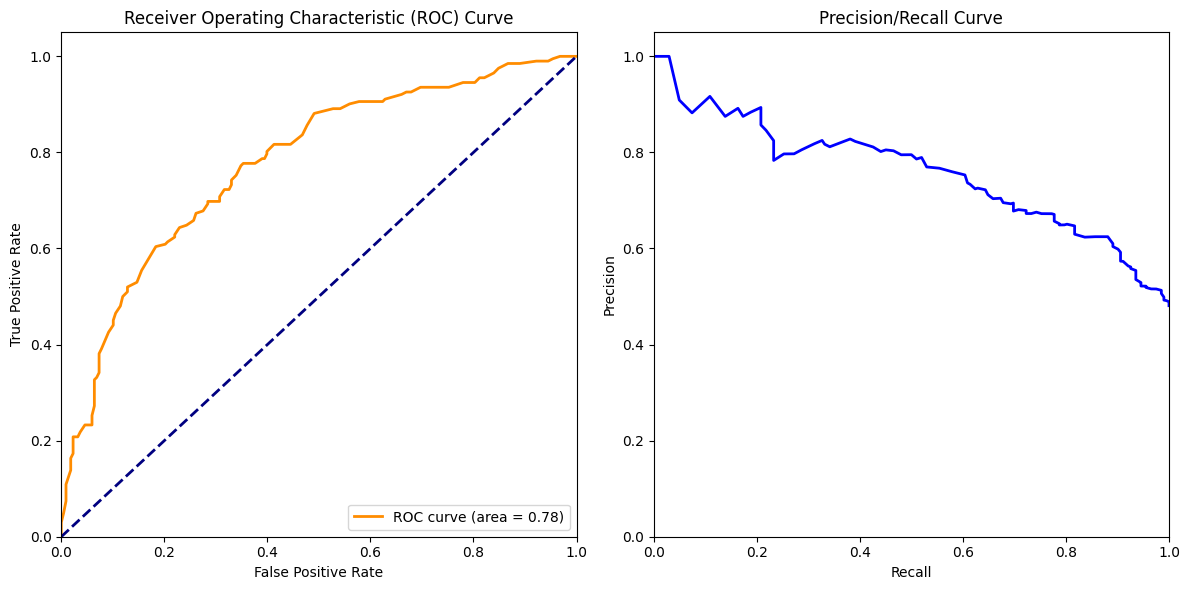

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 計算預測概率
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 繪製 Precision/Recall 曲線
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')

plt.tight_layout()
plt.show()


AUC: 0.7766600054500864


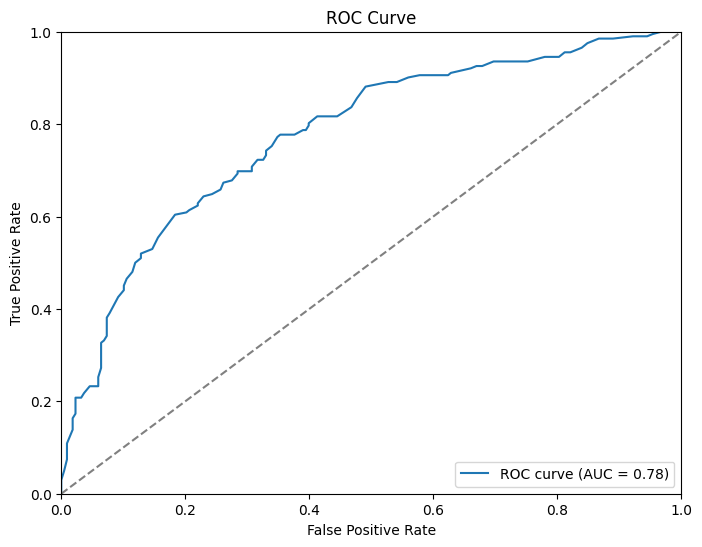

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# 預測概率
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# 計算 AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

# 繪製 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


AUC: 0.7766600054500864


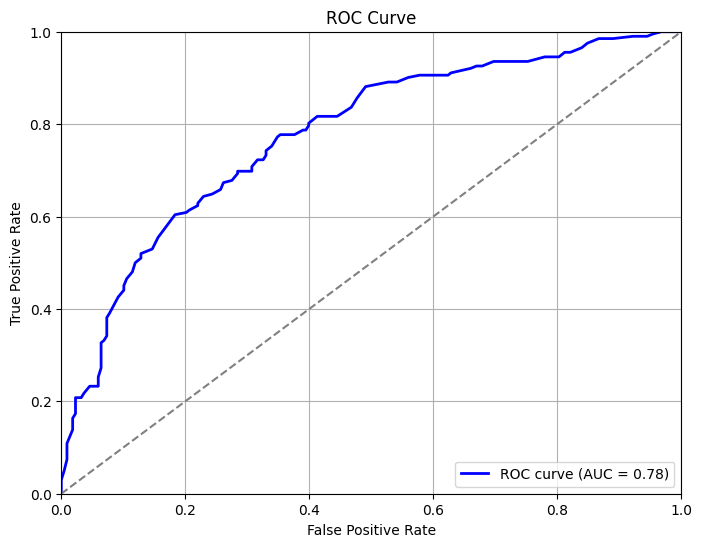

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# 預測概率
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# 計算 AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

# 繪製 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [ ]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


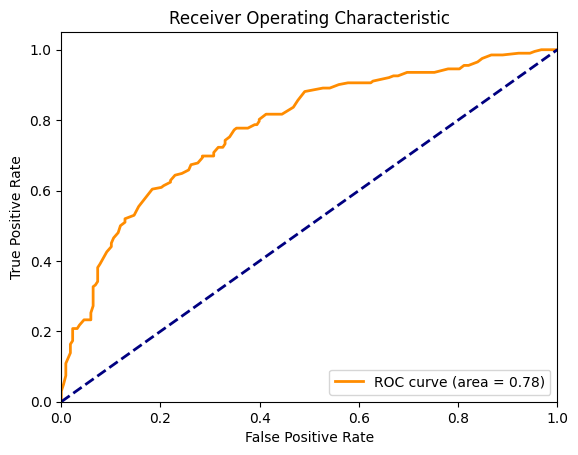

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
print(df.columns)


Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

# 加載數據
df = pd.read_csv("completed_data_transformed_final.csv")

# 分割特徵和目標變量
X = df.drop(columns=['Risk'])
y = df['Risk']

# 使用隨機森林進行特徵選擇
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(X, y)

# 選擇最重要的特徵
X_selected = selector.transform(X)
selected_features = X.columns[(selector.get_support())]

print("選擇的重要特徵：", selected_features)

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# 重新訓練模型
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 預測並評估模型
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


選擇的重要特徵： Index(['Age', 'Credit amount', 'Duration'], dtype='object')
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.83      0.77       209
         1.0       0.38      0.23      0.29        91

    accuracy                           0.65       300
   macro avg       0.54      0.53      0.53       300
weighted avg       0.61      0.65      0.62       300

